In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch

synsets = dict()
# Load synsets from a text file
# The file should contain lines in the format: "synset:name1,name2,..."
# where each synset is separated by a colon

with open('synsets.txt', 'r') as f:

    synsets_txt = f.read().splitlines()
    for syns in synsets_txt:
        syn_combo = syns.split(':')
        syn_names = syn_combo[1].split(',')
        if syn_combo[0] not in synsets:
            synsets[syn_combo[0]] = []
        for name in syn_names:
            if name not in synsets[syn_combo[0]]:
                synsets[syn_combo[0]].append(name)

# now check which synsets are in the val folder
synset_names = list(synsets.keys())
val_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\val"
val_synsets = [name for name in os.listdir(val_dir) if name in synset_names]

print(f"Found {len(val_synsets)} synsets in the validation folder.")

# synsets should be ordered by the order of the synset names in the validation folder
synsets = {k: synsets[k] for k in val_synsets if k in val_synsets}
id_to_synset = {i: syn for i, syn in enumerate(synsets.keys())}
synset_to_name = {syn: synsets[syn][0] for syn in synsets.keys()}

Found 200 synsets in the validation folder.


In [49]:
# dataset csv results look like this:
# index,prediction,target,correct
# 0, 123, 456, 0
# 1, 111, 111, 1
# every row is a prediction, with the index being the row number,

variants = ['baseline2', 'global', 'heatmap']
output_dir = r"C:\Users\joren\Documents\_Uni\Master\Thesis\output\vim_extra_tiny_custom_transforms_"

# Helper function to clean and convert dataframe columns
def clean_results_df(df):
    # Remove header and comment rows (non-numeric index)
    # Convert columns to appropriate types
    df['index'] = df['index'].astype(int)
    df['prediction'] = df['prediction'].astype(int)
    df['target'] = df['target'].astype(int)
    df['correct'] = df['correct'].astype(int)
    # Map prediction to synset
    df['synset'] = df['prediction'].map(id_to_synset)
    return df

def load_results(variant):
    results_file = os.path.join(output_dir + variant, "best_model_results.csv")
    if os.path.exists(results_file):
        df = pd.read_csv(results_file, names=['index', 'prediction', 'target', 'correct'], comment='#', header=0)
        df['index'] = df.index
        print(len(df), "results loaded for variant:", variant)
        return clean_results_df(df)
    else:
        print(f"Results file for variant '{variant}' not found at {results_file}.")
    
base_df = load_results(variants[0])
global_df = load_results(variants[1])
heatmap_df = load_results(variants[2])


10000 results loaded for variant: baseline2
10000 results loaded for variant: global
10000 results loaded for variant: heatmap


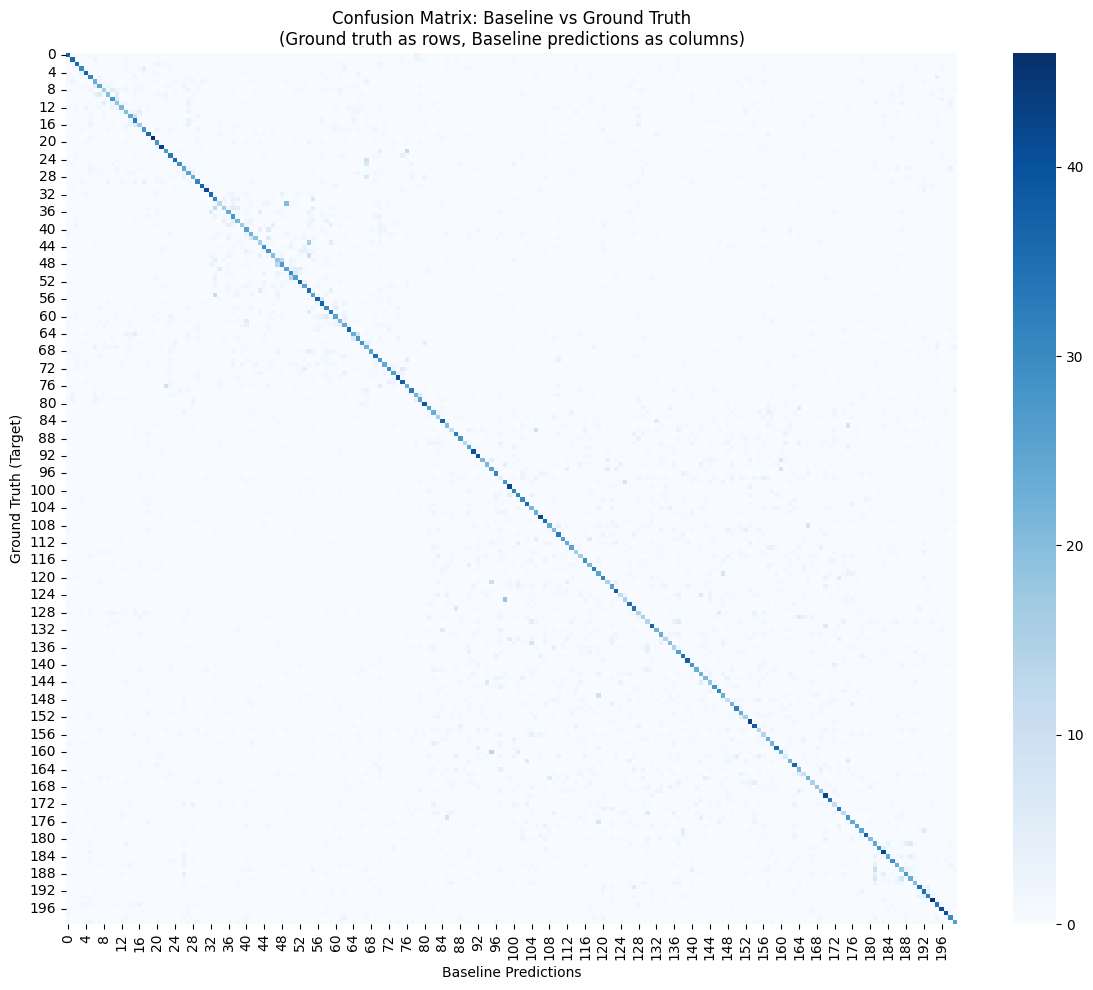

Baseline Overall Accuracy: 53.11%
Total predictions: 10000
Confusion matrix shape: (200, 200)
--------------------------------------------------


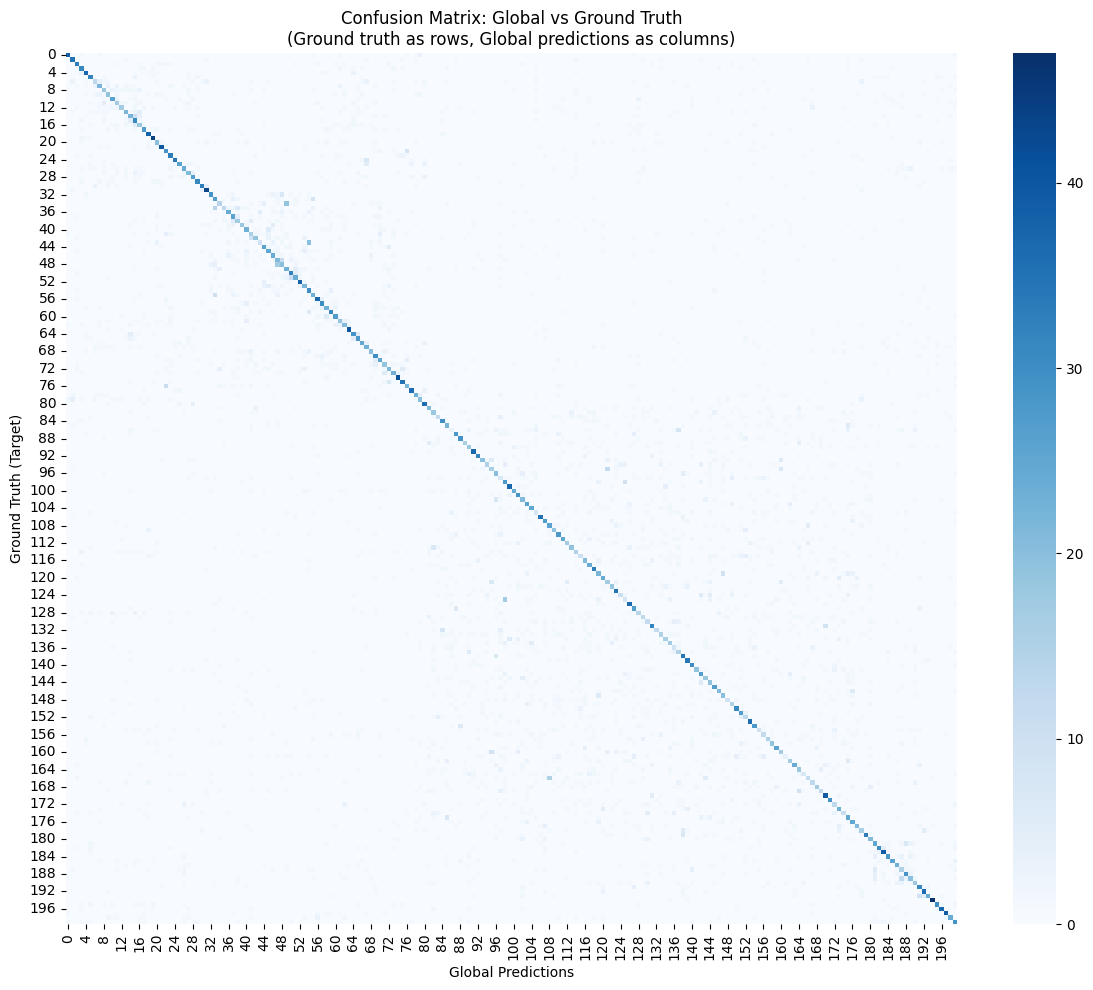

Global Overall Accuracy: 47.57%
Total predictions: 10000
Confusion matrix shape: (200, 200)
--------------------------------------------------


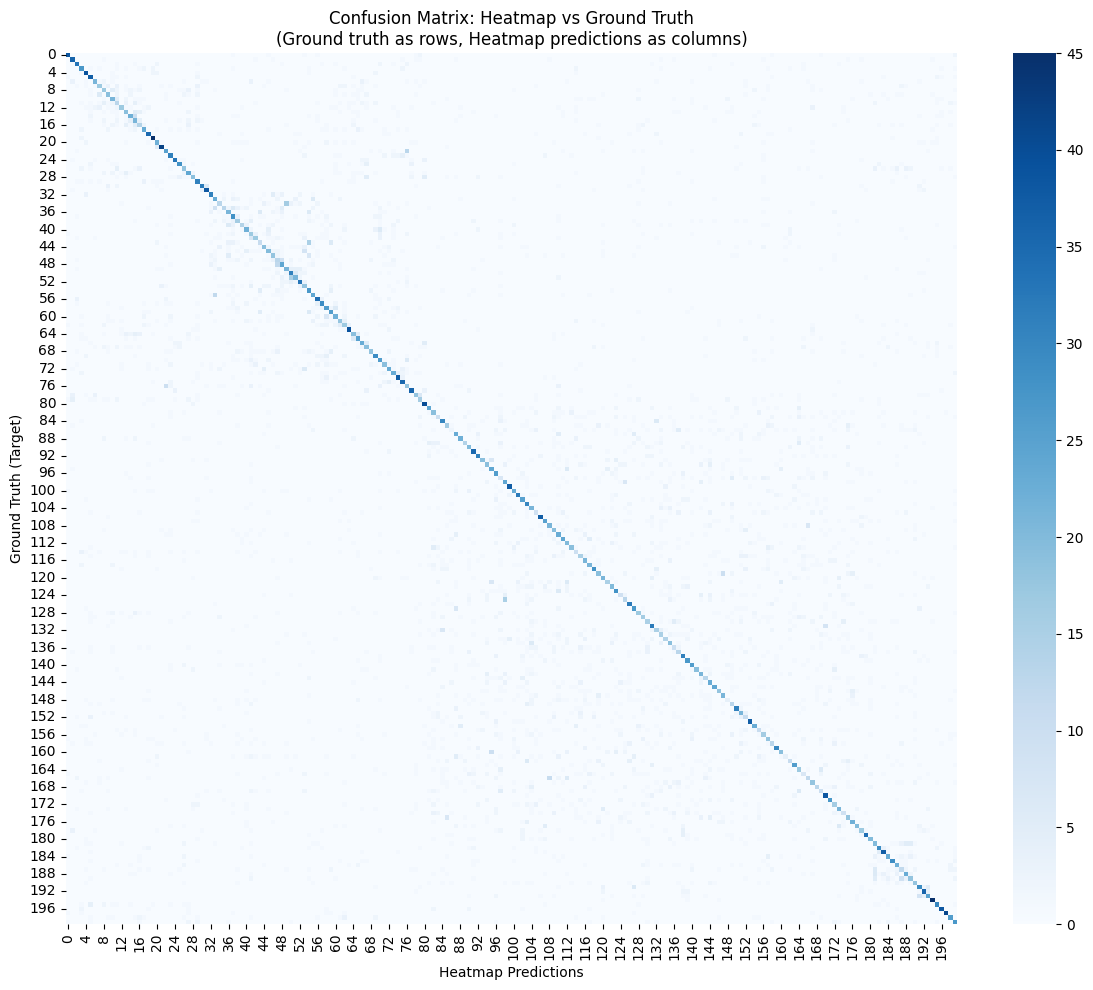

Heatmap Overall Accuracy: 45.20%
Total predictions: 10000
Confusion matrix shape: (200, 200)
--------------------------------------------------

Baseline - Top 10 Most Confused Class Pairs (min 10 confusions):
------------------------------------------------------------------------------------------------------------------------
Rank True Class   True Name                 Pred Class   Pred Name                 Count    Rate    
------------------------------------------------------------------------------------------------------------------------
1    n02089078     black-and-tan coonhound  n02106550     Rottweiler               20       0.400
2    n03782006     monitor                  n03180011     desktop computer         18       0.360
3    n02104029     kuvasz                   n02111889     Samoyed                  16       0.320
4    n02105855     Shetland sheepdog        n02106030     collie                   13       0.260
5    n02106030     collie                   n02105855  

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrices for each model against ground truth
model_names = ['Baseline', 'Global', 'Heatmap']
model_dfs = [base_df, global_df, heatmap_df]

# Function to create and plot confusion matrix for a model against ground truth
def plot_confusion_matrix_vs_truth(df, model_name):
    # Get predictions and targets
    predictions = df['prediction']
    targets = df['target']
    
    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
    plt.title(f'Confusion Matrix: {model_name} vs Ground Truth\n(Ground truth as rows, {model_name} predictions as columns)')
    plt.ylabel('Ground Truth (Target)')
    plt.xlabel(f'{model_name} Predictions')
    plt.tight_layout()
    plt.show()
    
    # Calculate overall accuracy
    accuracy = (predictions == targets).sum() / len(predictions) * 100
    print(f"{model_name} Overall Accuracy: {accuracy:.2f}%")
    print(f"Total predictions: {len(predictions)}")
    print(f"Confusion matrix shape: {cm.shape}")
    print("-" * 50)

# Generate confusion matrices for each model vs ground truth
for i, model_name in enumerate(model_names):
    plot_confusion_matrix_vs_truth(model_dfs[i], model_name)
    # Function to analyze and plot most confused classes
def analyze_confused_classes(df, model_name, top_n=10, min_confusion_threshold=10):
    """
    Analyze which classes are most confused with each other
    
    Args:
        df: DataFrame with prediction results
        model_name: Name of the model for display
        top_n: Number of top confused pairs to show
        min_confusion_threshold: Minimum number of confusions to consider
    """
    # Get predictions and targets
    predictions = df['prediction']
    targets = df['target']
    
    # Create confusion matrix
    cm = confusion_matrix(targets, predictions)
    
    # Find most confused pairs (excluding diagonal - correct predictions)
    confused_pairs = []
    
    for true_class in range(cm.shape[0]):
        for pred_class in range(cm.shape[1]):
            if true_class != pred_class:  # Exclude correct predictions
                confusion_count = cm[true_class, pred_class]
                if confusion_count >= min_confusion_threshold:
                    # Get class names
                    true_synset = id_to_synset[true_class]
                    pred_synset = id_to_synset[pred_class]
                    true_name = synset_to_name[true_synset]
                    pred_name = synset_to_name[pred_synset]
                    
                    confused_pairs.append({
                        'true_class': true_class,
                        'pred_class': pred_class,
                        'true_synset': true_synset,
                        'pred_synset': pred_synset,
                        'true_name': true_name,
                        'pred_name': pred_name,
                        'confusion_count': confusion_count,
                        'confusion_rate': confusion_count / cm[true_class].sum()
                    })
    
    # Sort by confusion count
    confused_pairs.sort(key=lambda x: x['confusion_count'], reverse=True)
    
    # Display top confused pairs
    print(f"\n{model_name} - Top {top_n} Most Confused Class Pairs (min {min_confusion_threshold} confusions):")
    print("-" * 120)
    print(f"{'Rank':<4} {'True Class':<12} {'True Name':<25} {'Pred Class':<12} {'Pred Name':<25} {'Count':<8} {'Rate':<8}")
    print("-" * 120)
    
    for i, pair in enumerate(confused_pairs[:top_n]):
        print(f"{i+1:<4} {pair['true_synset']:<12} {pair['true_name'][:24]:<25} "
                f"{pair['pred_synset']:<12} {pair['pred_name'][:24]:<25} "
                f"{pair['confusion_count']:<8} {pair['confusion_rate']:.3f}")
    
    print(f"\nTotal confused pairs with >= {min_confusion_threshold} confusions: {len(confused_pairs)}")
    
    return confused_pairs

# Analyze confused classes for each model
for i, model_name in enumerate(model_names):
    confused_pairs = analyze_confused_classes(model_dfs[i], model_name, top_n=10, min_confusion_threshold=10)


Bonferroni corrected alpha level: 0.016667 (original alpha: 0.05, 3 comparisons)

McNemar's Test Results for Model Comparisons

Baseline vs Global
----------------------------------------
McNemar Contingency Table:
                    Global Correct  Global Wrong
Baseline Correct         3938         1373
Baseline Wrong            819         3870

Baseline Accuracy: 0.5311 (5311/10000)
Global Accuracy: 0.4757 (4757/10000)

McNemar's Test:
Chi-square statistic: 139.5114
P-value: 0.000000
Uncorrected significance (α = 0.05): Yes
Bonferroni corrected significance (α = 0.016667): Yes
Result: Significant difference after Bonferroni correction
        Baseline performs significantly better than Global
Odds ratio (discordant pairs): 1.6764
        Baseline is 1.68x more likely to be correct when models disagree

Baseline vs Heatmap
----------------------------------------
McNemar Contingency Table:
                    Heatmap Correct  Heatmap Wrong
Baseline Correct         3777         1534


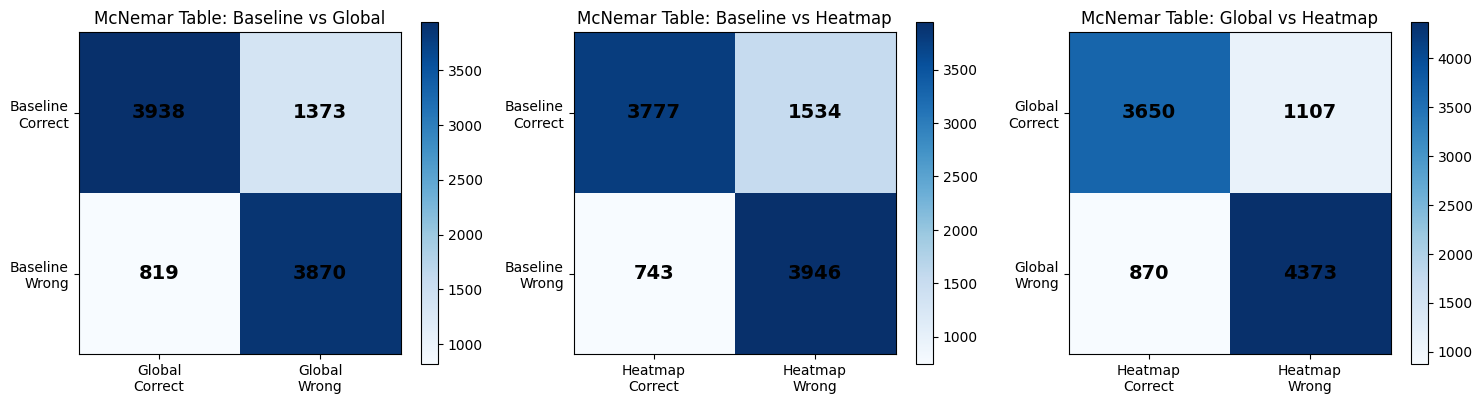

In [56]:
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q
from scipy.stats import chi2
import numpy as np
import matplotlib.pyplot as plt

def mcnemar_comparison(df1, df2, model1_name, model2_name):
    """
    Perform McNemar's test between two models
    
    Args:
        df1, df2: DataFrames with prediction results
        model1_name, model2_name: Names for display
    
    Returns:
        Contingency table and test results
    """
    # Get correct/incorrect for each model
    correct1 = df1['correct'].values
    correct2 = df2['correct'].values
    
    # Create McNemar contingency table
    # Table format:
    #           Model2 Correct  Model2 Wrong
    # Model1 Correct      a          b
    # Model1 Wrong        c          d
    
    a = np.sum((correct1 == 1) & (correct2 == 1))  # Both correct
    b = np.sum((correct1 == 1) & (correct2 == 0))  # Model1 correct, Model2 wrong
    c = np.sum((correct1 == 0) & (correct2 == 1))  # Model1 wrong, Model2 correct
    d = np.sum((correct1 == 0) & (correct2 == 0))  # Both wrong
    
    # Create contingency table
    contingency_table = np.array([[a, b], [c, d]])
    
    # Perform McNemar's test
    # Only uses b and c (discordant pairs)
    result = mcnemar(contingency_table, exact=False, correction=True)
    
    return contingency_table, result, (a, b, c, d)

def cochran_q_test(dfs, model_names):
    """
    Perform Cochran's Q test for multiple models using statsmodels
    
    Args:
        dfs: List of DataFrames with prediction results
        model_names: List of model names
    
    Returns:
        Q statistic, p-value, and detailed results
    """
    # Create matrix where rows are samples and columns are models
    n_samples = len(dfs[0])
    n_models = len(dfs)
    
    # Binary outcome matrix (1 = correct, 0 = incorrect)
    outcomes = np.zeros((n_samples, n_models))
    for i, df in enumerate(dfs):
        outcomes[:, i] = df['correct'].values
    
    # Use statsmodels cochrans_q function
    result = cochrans_q(outcomes)
    
    # Calculate additional statistics for reporting
    col_sums = np.sum(outcomes, axis=0)
    grand_total = np.sum(col_sums)
    
    return result.statistic, result.pvalue, col_sums, grand_total, n_samples

# Perform McNemar tests for all model pairs with Bonferroni correction
# Number of comparisons for Bonferroni correction
model_pairs = [
    (base_df, global_df, 'Baseline', 'Global'),
    (base_df, heatmap_df, 'Baseline', 'Heatmap'),
    (global_df, heatmap_df, 'Global', 'Heatmap')
]

n_comparisons = len(model_pairs)
bonferroni_alpha = 0.05 / n_comparisons
print(f"Bonferroni corrected alpha level: {bonferroni_alpha:.6f} (original alpha: 0.05, {n_comparisons} comparisons)")
print()
print("McNemar's Test Results for Model Comparisons")
print("=" * 60)

for df1, df2, name1, name2 in model_pairs:
    print(f"\n{name1} vs {name2}")
    print("-" * 40)
    
    contingency_table, mcnemar_result, (a, b, c, d) = mcnemar_comparison(df1, df2, name1, name2)
    
    # Display contingency table
    print(f"McNemar Contingency Table:")
    print(f"                    {name2} Correct  {name2} Wrong")
    print(f"{name1} Correct        {a:5d}        {b:5d}")
    print(f"{name1} Wrong          {c:5d}        {d:5d}")
    print()
    
    # Calculate accuracies
    acc1 = (a + b) / (a + b + c + d)
    acc2 = (a + c) / (a + b + c + d)
    
    print(f"{name1} Accuracy: {acc1:.4f} ({a + b}/{a + b + c + d})")
    print(f"{name2} Accuracy: {acc2:.4f} ({a + c}/{a + b + c + d})")
    print()
    
    # McNemar test results
    print(f"McNemar's Test:")
    print(f"Chi-square statistic: {mcnemar_result.statistic:.4f}")
    print(f"P-value: {mcnemar_result.pvalue:.6f}")
    
    # Interpretation with Bonferroni correction
    print(f"Uncorrected significance (α = 0.05): {'Yes' if mcnemar_result.pvalue < 0.05 else 'No'}")
    print(f"Bonferroni corrected significance (α = {bonferroni_alpha:.6f}): {'Yes' if mcnemar_result.pvalue < bonferroni_alpha else 'No'}")
    
    if mcnemar_result.pvalue < bonferroni_alpha:
        if b > c:
            better_model = name1
            worse_model = name2
        else:
            better_model = name2
            worse_model = name1
        print(f"Result: Significant difference after Bonferroni correction")
        print(f"        {better_model} performs significantly better than {worse_model}")
    else:
        if mcnemar_result.pvalue < 0.05:
            print(f"Result: Significant without correction, but NOT significant after Bonferroni correction")
            print(f"        Suggests weak evidence of difference")
        else:
            print(f"Result: No significant difference")
            print(f"        Models perform similarly")
    
    # Effect size (odds ratio for discordant pairs)
    if c > 0:
        odds_ratio = b / c
        print(f"Odds ratio (discordant pairs): {odds_ratio:.4f}")
        if odds_ratio > 1:
            print(f"        {name1} is {odds_ratio:.2f}x more likely to be correct when models disagree")
        else:
            print(f"        {name2} is {1/odds_ratio:.2f}x more likely to be correct when models disagree")
    else:
        print("Odds ratio: undefined (no cases where Model1 wrong and Model2 correct)")

# Perform Cochran's Q test
print("\n\nCochran's Q Test for All Models")
print("=" * 60)

q_stat, p_value, col_sums, grand_total, n_samples = cochran_q_test([base_df, global_df, heatmap_df], model_names)

print(f"Number of samples: {n_samples}")
print(f"Model accuracies:")
for i, (name, correct_count) in enumerate(zip(model_names, col_sums)):
    accuracy = correct_count / n_samples
    print(f"  {name}: {accuracy:.4f} ({correct_count}/{n_samples})")

print(f"\nCochran's Q statistic: {q_stat:.4f}")
print(f"Degrees of freedom: {len(model_names) - 1}")
print(f"P-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nResult: Significant difference between models (p < {alpha})")
    print("        At least one model performs significantly differently from the others")
    print("        Note: Cochran's Q is an omnibus test - no multiple comparison correction needed")
else:
    print(f"\nResult: No significant difference between models (p >= {alpha})")
    print("        All models perform similarly")

# Visualize the contingency tables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (df1, df2, name1, name2) in enumerate(model_pairs):
    contingency_table, _, (a, b, c, d) = mcnemar_comparison(df1, df2, name1, name2)
    
    # Create heatmap
    im = axes[idx].imshow(contingency_table, cmap='Blues', aspect='equal')
    
    # Add text annotations
    axes[idx].text(0, 0, f'{a}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(1, 0, f'{b}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(0, 1, f'{c}', ha='center', va='center', fontsize=14, fontweight='bold')
    axes[idx].text(1, 1, f'{d}', ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Set labels
    axes[idx].set_xticks([0, 1])
    axes[idx].set_yticks([0, 1])
    axes[idx].set_xticklabels([f'{name2}\nCorrect', f'{name2}\nWrong'])
    axes[idx].set_yticklabels([f'{name1}\nCorrect', f'{name1}\nWrong'])
    axes[idx].set_title(f'McNemar Table: {name1} vs {name2}')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

In [58]:
from scipy.stats import chi2
from statsmodels.stats.multitest import multipletests
import pandas as pd
import numpy as np

def per_class_mcnemar_test(df1, df2, model1_name, model2_name, alpha=0.05):
    """
    Perform McNemar's test for each class between two models
    
    Args:
        df1, df2: DataFrames with prediction results
        model1_name, model2_name: Names for display
        alpha: Significance level for multiple testing correction
    
    Returns:
        DataFrame with per-class McNemar results
    """
    # Get unique classes (synsets)
    unique_synsets = sorted(df1['synset'].unique())
    
    results = []
    
    for synset in unique_synsets:
        try:
            # Filter data for this class
            class_mask1 = df1['synset'] == synset
            class_mask2 = df2['synset'] == synset
            
            # Get correct/incorrect for this class
            correct1 = df1.loc[class_mask1, 'correct'].values
            correct2 = df2.loc[class_mask2, 'correct'].values
            
            # Ensure same number of samples - if not, use a more reliable approach
            if len(correct1) != len(correct2):
                print(f"Warning: Sample count mismatch for synset {synset}. "
                      f"{model1_name}: {len(correct1)}, {model2_name}: {len(correct2)}")
                
                # Use image indices to align samples
                df1_indices = set(df1.loc[class_mask1, 'index'].values)
                df2_indices = set(df2.loc[class_mask2, 'index'].values)
                common_indices = df1_indices.intersection(df2_indices)
                
                if not common_indices:
                    print(f"  No common samples found for {synset}, skipping.")
                    continue
                    
                print(f"  Using {len(common_indices)} common samples instead.")
                
                # Filter to common indices
                df1_common = df1[df1['index'].isin(common_indices) & class_mask1]
                df2_common = df2[df2['index'].isin(common_indices) & class_mask2]
                
                # Sort by index to ensure alignment
                df1_common = df1_common.sort_values(by='index')
                df2_common = df2_common.sort_values(by='index')
                
                correct1 = df1_common['correct'].values
                correct2 = df2_common['correct'].values
            
            n_images = len(correct1)
            
            if n_images == 0:
                continue
                
            # Calculate accuracies
            acc1 = np.mean(correct1)
            acc2 = np.mean(correct2)
            
            # Create McNemar contingency table
            a = np.sum((correct1 == 1) & (correct2 == 1))  # Both correct
            b = np.sum((correct1 == 1) & (correct2 == 0))  # Model1 correct, Model2 wrong
            c = np.sum((correct1 == 0) & (correct2 == 1))  # Model1 wrong, Model2 correct
            d = np.sum((correct1 == 0) & (correct2 == 0))  # Both wrong
            
            # McNemar's test statistic (with continuity correction)
            if b + c > 0:
                chi2_stat = ((abs(b - c) - 1) ** 2) / (b + c)
                p_value = 1 - chi2.cdf(chi2_stat, df=1)
            else:
                # No discordant pairs - models perform identically
                chi2_stat = 0.0
                p_value = 1.0
            
            # Calculate effect size (odds ratio for discordant pairs)
            if c > 0:
                odds_ratio = b / c
            elif b > 0:
                odds_ratio = float('inf')  # Model1 always better when they disagree
            else:
                odds_ratio = 1.0  # No disagreement
            
            results.append({
                'synset': synset,
                'synset_name': synset_to_name.get(synset, 'Unknown'),
                'n_images': n_images,
                f'{model1_name}_accuracy': acc1,
                f'{model2_name}_accuracy': acc2,
                'accuracy_diff': acc1 - acc2,
                'mcnemar_chi2': chi2_stat,
                'p_value': p_value,
                'odds_ratio': odds_ratio,
                'a_both_correct': a,
                'b_model1_only': b,
                'c_model2_only': c,
                'd_both_wrong': d
            })
        except Exception as e:
            print(f"Error processing synset {synset}: {str(e)}")
            continue
    
    results_df = pd.DataFrame(results)
    
    # Apply multiple testing correction
    if len(results_df) > 0:
        # Benjamini-Hochberg (FDR control)
        rejected_bh, pvals_corrected_bh, _, _ = multipletests(
            results_df['p_value'], alpha=alpha, method='fdr_bh'
        )
        
        # Bonferroni (FWER control)
        rejected_bonf, pvals_corrected_bonf, _, _ = multipletests(
            results_df['p_value'], alpha=alpha, method='bonferroni'
        )
        
        results_df['p_value_bh_corrected'] = pvals_corrected_bh
        results_df['significant_bh'] = rejected_bh
        results_df['p_value_bonferroni_corrected'] = pvals_corrected_bonf
        results_df['significant_bonferroni'] = rejected_bonf
    
    return results_df

# Perform per-class McNemar tests for all model pairs
print("Per-Class McNemar Test Analysis")
print("=" * 80)

per_class_results = {}

for df1, df2, name1, name2 in model_pairs:
    print(f"\n{name1} vs {name2}")
    print("-" * 60)
    
    results_df = per_class_mcnemar_test(df1, df2, name1, name2)
    per_class_results[f"{name1}_vs_{name2}"] = results_df
    
    # Summary statistics
    total_classes = len(results_df)
    sig_bh = results_df['significant_bh'].sum()
    sig_bonf = results_df['significant_bonferroni'].sum()
    
    print(f"Total classes analyzed: {total_classes}")
    print(f"Significant differences (Benjamini-Hochberg, α=0.05): {sig_bh}")
    print(f"Significant differences (Bonferroni, α=0.05): {sig_bonf}")
    
    if sig_bh > 0:
        # Show classes with significant differences (BH corrected)
        sig_classes = results_df[results_df['significant_bh']].sort_values('p_value')
        print(f"\nTop classes with significant differences (BH corrected):")
        print(f"{'Synset':<12} {'Name':<25} {'Acc_Diff':<10} {'Chi2':<8} {'p-val':<10} {'OR':<8}")
        print("-" * 80)
        
        for _, row in sig_classes.head(10).iterrows():
            print(f"{row['synset']:<12} {row['synset_name'][:24]:<25} "
                  f"{row['accuracy_diff']:>8.3f} {row['mcnemar_chi2']:>7.2f} "
                  f"{row['p_value']:>9.6f} {row['odds_ratio']:>7.2f}")
    
    # Show top classes by effect size (regardless of significance)
    print(f"\nTop classes by absolute accuracy difference:")
    top_diff = results_df.reindex(results_df['accuracy_diff'].abs().sort_values(ascending=False).index)
    print(f"{'Synset':<12} {'Name':<25} {'Acc_Diff':<10} {'n_imgs':<8} {'Sig_BH':<8}")
    print("-" * 75)
    
    for _, row in top_diff.head(10).iterrows():
        sig_marker = "***" if row['significant_bh'] else ""
        print(f"{row['synset']:<12} {row['synset_name'][:24]:<25} "
              f"{row['accuracy_diff']:>8.3f} {row['n_images']:>7d} {sig_marker:<8}")

# Create summary visualization of significant differences
print(f"\n\nSummary of Per-Class Significant Differences")
print("=" * 80)

summary_data = []
for comparison, results_df in per_class_results.items():
    model1, model2 = comparison.split('_vs_')
    
    # Count classes where each model is significantly better
    sig_classes = results_df[results_df['significant_bh']]
    
    model1_better = sig_classes[sig_classes['accuracy_diff'] > 0]
    model2_better = sig_classes[sig_classes['accuracy_diff'] < 0]
    
    summary_data.append({
        'Comparison': comparison,
        'Model1': model1,
        'Model2': model2,
        'Total_Classes': len(results_df),
        'Sig_Differences_BH': sig_classes.shape[0],
        'Model1_Better': len(model1_better),
        'Model2_Better': len(model2_better),
        'Avg_Effect_Size': results_df['accuracy_diff'].abs().mean(),
        'Max_Difference': results_df['accuracy_diff'].abs().max()
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Store results for potential further analysis
baseline_vs_global = per_class_results['Baseline_vs_Global']
baseline_vs_heatmap = per_class_results['Baseline_vs_Heatmap'] 
global_vs_heatmap = per_class_results['Global_vs_Heatmap']

Per-Class McNemar Test Analysis

Baseline vs Global
------------------------------------------------------------
  Using 36 common samples instead.
  Using 39 common samples instead.
  Using 36 common samples instead.
  Using 34 common samples instead.
  Using 36 common samples instead.
  Using 35 common samples instead.
  Using 14 common samples instead.
  Using 18 common samples instead.
  Using 19 common samples instead.
  Using 22 common samples instead.
  Using 14 common samples instead.
  Using 18 common samples instead.
  Using 22 common samples instead.
  Using 44 common samples instead.
  Using 20 common samples instead.
  Using 24 common samples instead.
  Using 35 common samples instead.
  Using 44 common samples instead.
  Using 28 common samples instead.
  Using 40 common samples instead.
  Using 34 common samples instead.
  Using 41 common samples instead.
  Using 33 common samples instead.
  Using 22 common samples instead.
  Using 28 common samples instead.
  Using 22 c

Top 20 most similar synsets (by accuracy range): ['n07714990', 'n02098105', 'n01860187', 'n02966193', 'n12620546', 'n02117135', 'n03776460', 'n03998194', 'n04208210', 'n02088364', 'n13052670', 'n03141823', 'n02916936', 'n01984695', 'n04486054', 'n01917289', 'n02492660', 'n02091134', 'n04070727', 'n04192698']
Top 20 most different synsets (by accuracy range): ['n02443114', 'n02815834', 'n02102480', 'n03538406', 'n03782006', 'n02011460', 'n02483708', 'n02974003', 'n03126707', 'n03443371', 'n04532670', 'n03355925', 'n06794110', 'n02835271', 'n02116738', 'n04479046', 'n03388549', 'n04039381', 'n01773549', 'n09193705']


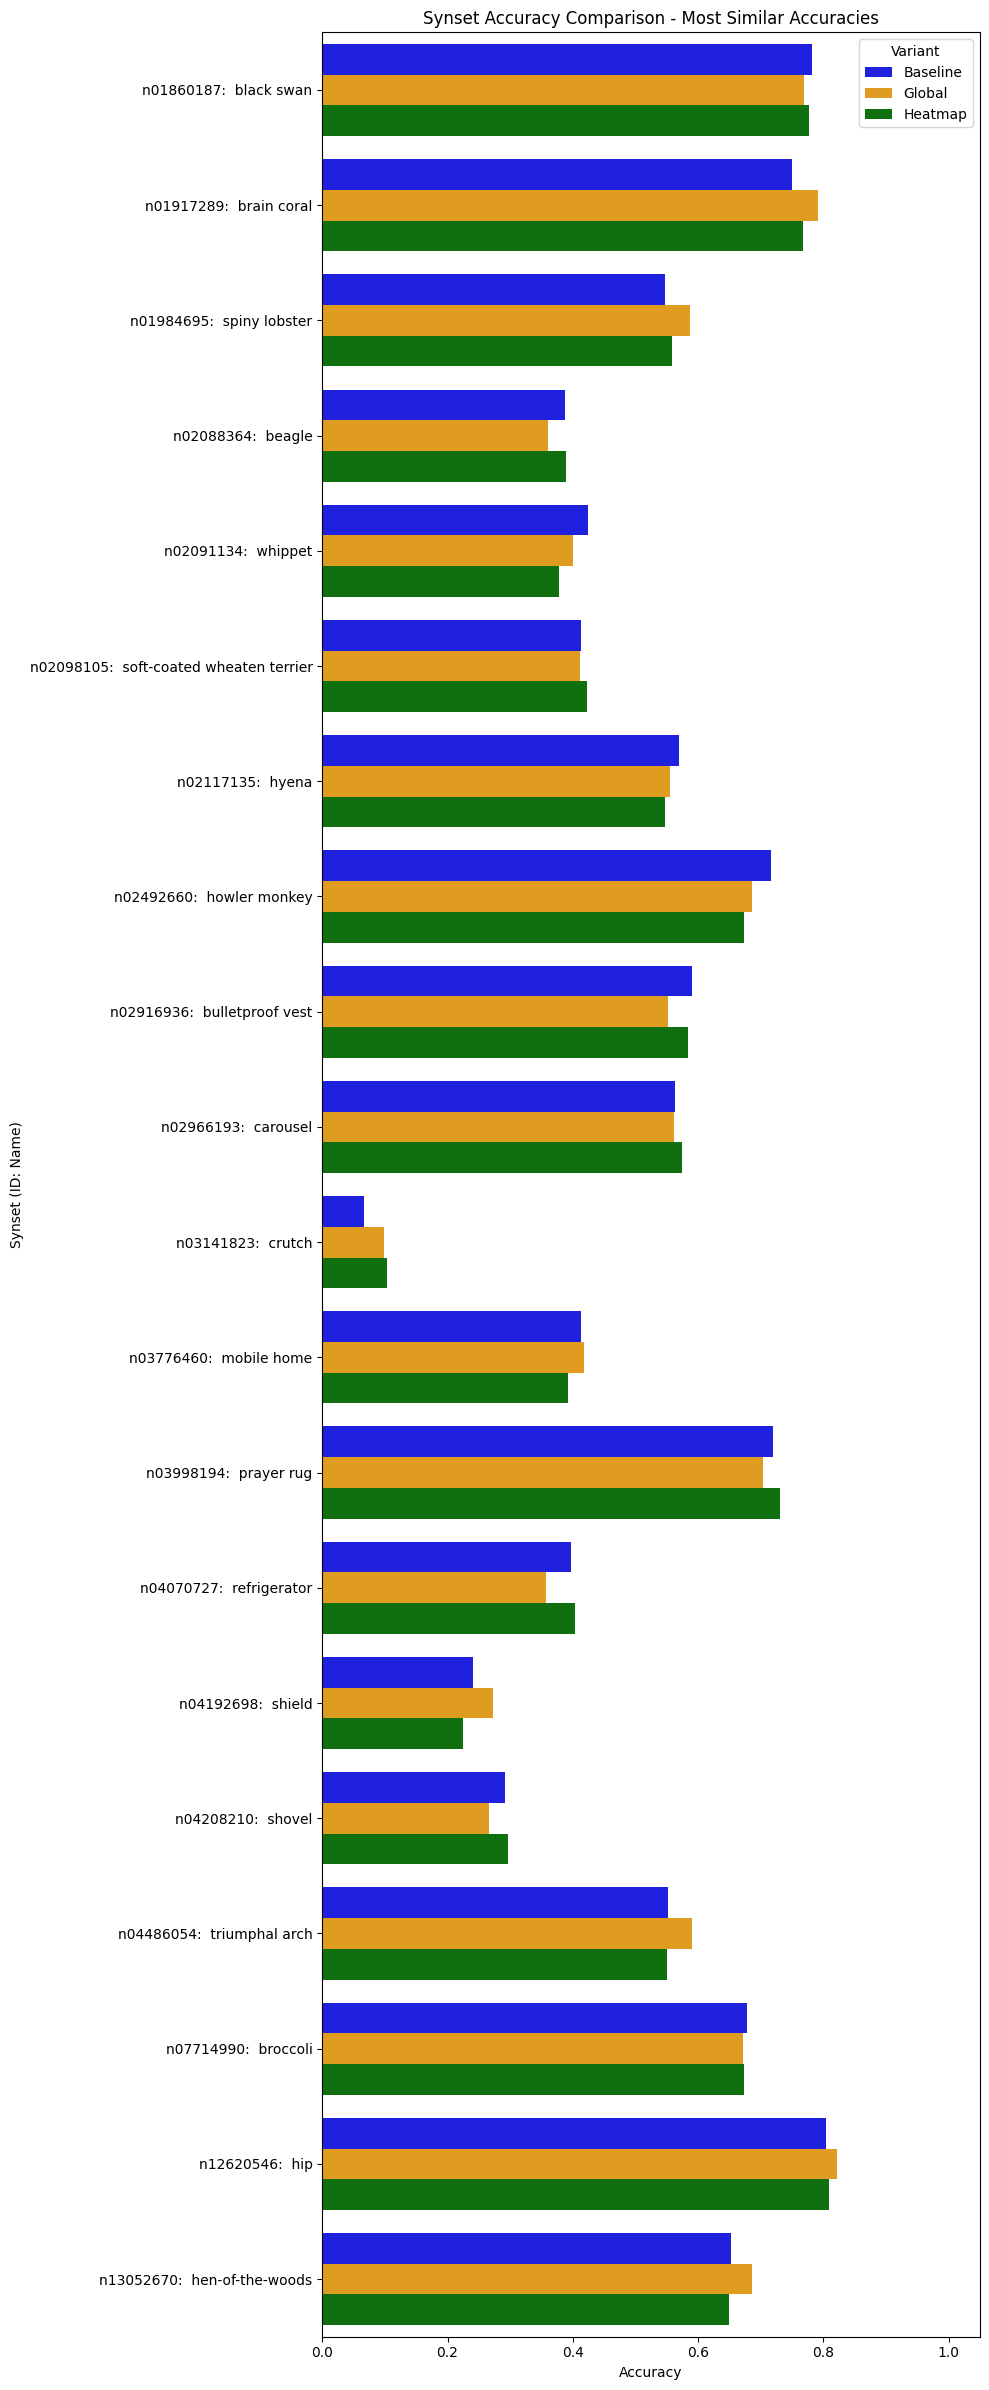

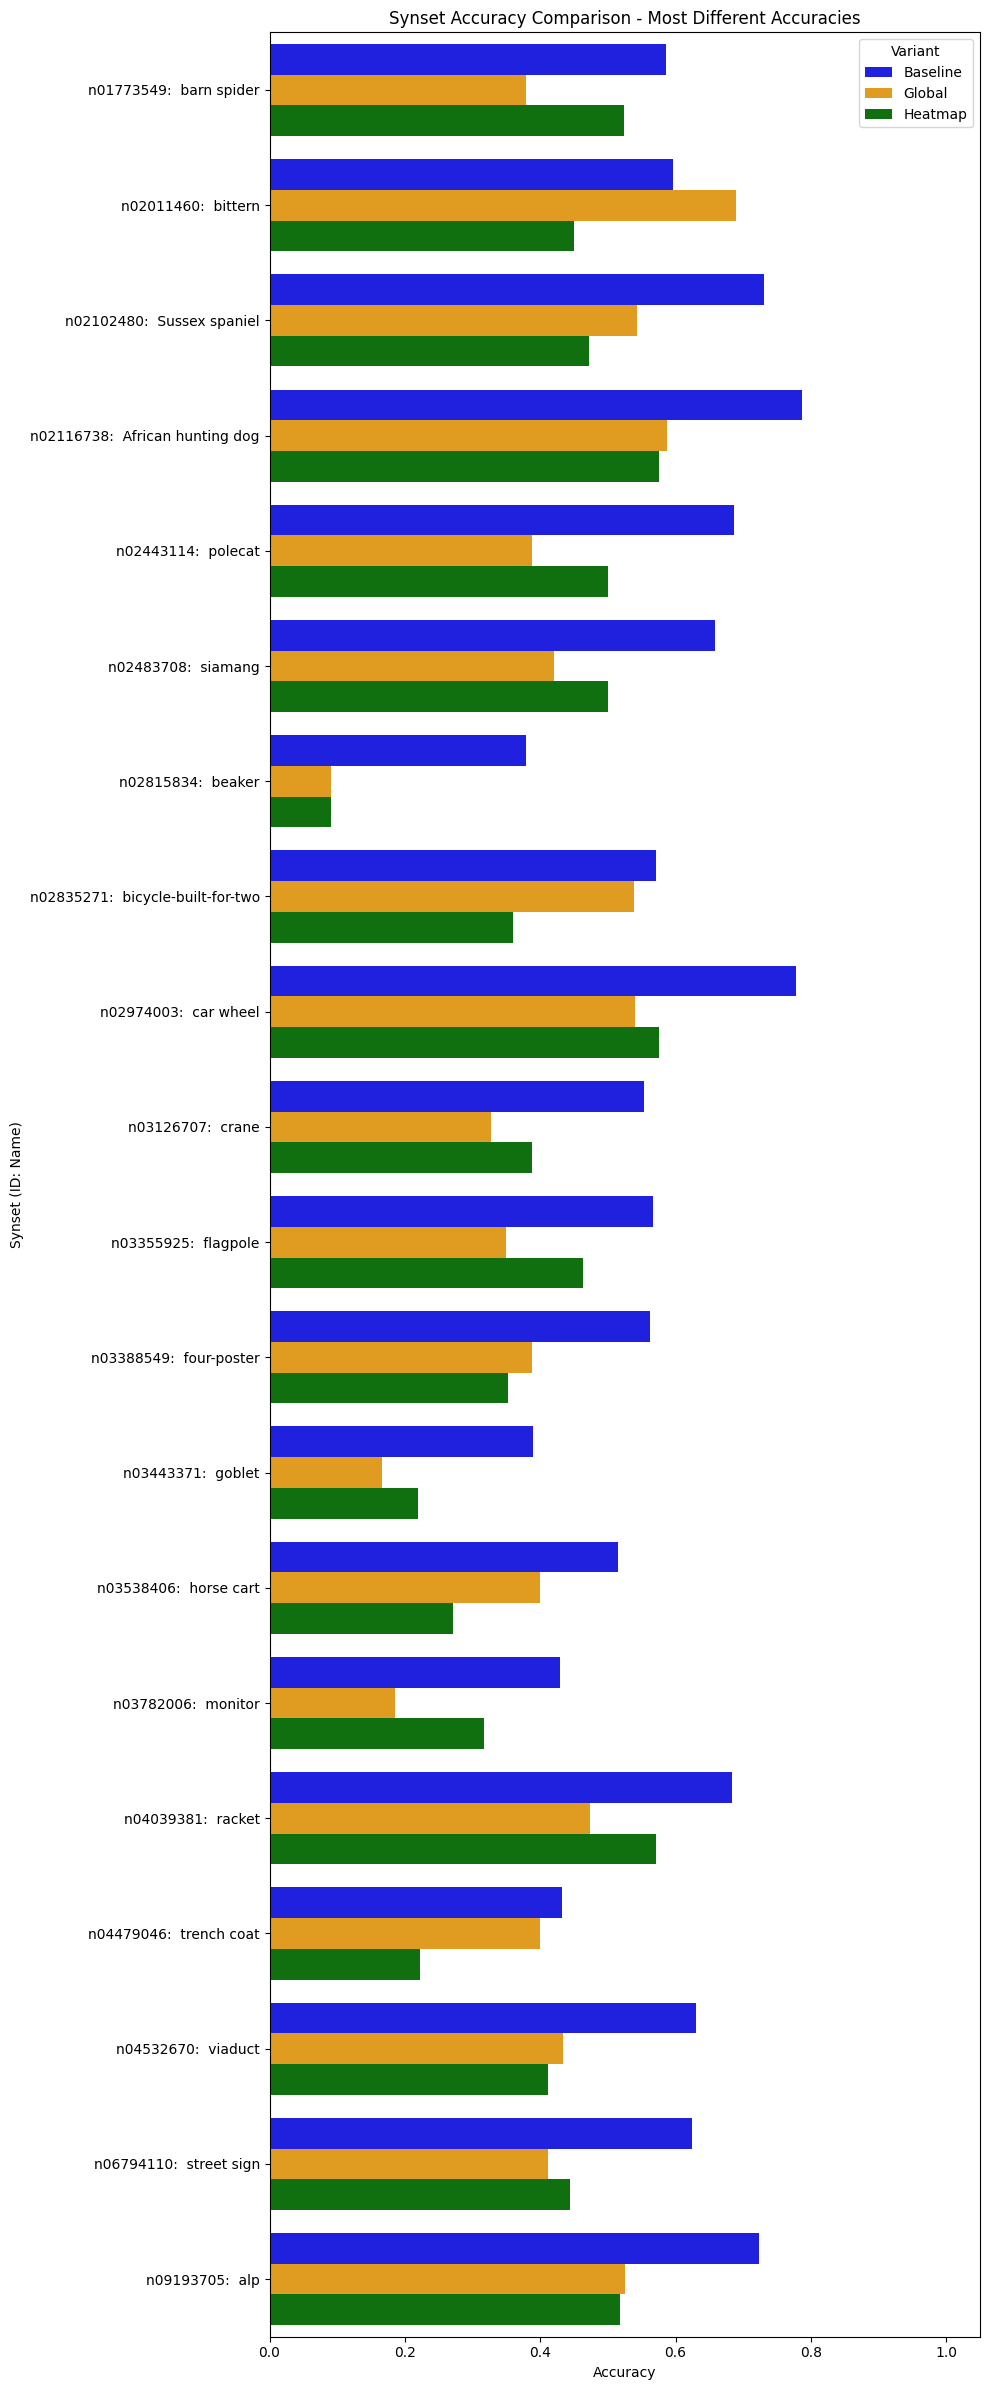

In [59]:

def calculate_accuracy(df):
    accuracy = df.groupby('synset').agg({'correct': 'mean'}).reset_index()
    accuracy.columns = ['synset', 'accuracy']
    return accuracy

base_accuracy = calculate_accuracy(base_df)
global_accuracy = calculate_accuracy(global_df)
heatmap_accuracy = calculate_accuracy(heatmap_df)

# Merge the accuracy dataframes
acc_df_list = [base_accuracy.set_index('synset'), global_accuracy.set_index('synset'), heatmap_accuracy.set_index('synset')]
all_accuracies_merged = pd.concat(acc_df_list, axis=1, keys=['Baseline', 'Global', 'Heatmap'])
all_accuracies_merged.columns = all_accuracies_merged.columns.droplevel(1) # Drop the 'accuracy' level from multi-index

# Calculate the range of accuracies for each synset
all_accuracies_merged['accuracy_range'] = all_accuracies_merged.max(axis=1) - all_accuracies_merged.min(axis=1)
all_accuracies_merged['accuracy_std'] = all_accuracies_merged[['Baseline', 'Global', 'Heatmap']].std(axis=1)

# Sort by the range or std to find most similar and most different
k_most_simdif = 20
most_similar_synsets = all_accuracies_merged.sort_values(by='accuracy_range').head(k_most_simdif).index.tolist()
most_different_synsets = all_accuracies_merged.sort_values(by='accuracy_range', ascending=False).head(k_most_simdif).index.tolist()

print(f"Top {k_most_simdif} most similar synsets (by accuracy range): {most_similar_synsets}")
print(f"Top {k_most_simdif} most different synsets (by accuracy range): {most_different_synsets}")

# --- Modified plotting function ---
# Now we can plot the accuracies
def plot_accuracies_subplot(base_acc, global_acc, heatmap_acc, synset_list, title_suffix=""):
    # Combine the accuracy dataframes for easier plotting with seaborn
    base_acc_filtered = base_acc[base_acc['synset'].isin(synset_list)].copy()
    global_acc_filtered = global_acc[global_acc['synset'].isin(synset_list)].copy()
    heatmap_acc_filtered = heatmap_acc[heatmap_acc['synset'].isin(synset_list)].copy()

    base_acc_filtered['variant'] = 'Baseline'
    global_acc_filtered['variant'] = 'Global'
    heatmap_acc_filtered['variant'] = 'Heatmap'
    
    combined_acc = pd.concat([base_acc_filtered, global_acc_filtered, heatmap_acc_filtered])
    
    if combined_acc.empty:
        print(f"No data to plot for synsets: {synset_list} with suffix: {title_suffix}")
        return
    
    # Map synset IDs to names
    combined_acc['synset_name_only'] = combined_acc['synset'].map(synset_to_name)
    # Create a combined display name (ID: Name)
    combined_acc['synset_display_name'] = combined_acc['synset'] + ": " + combined_acc['synset_name_only']

    # Adjust figsize for horizontal bars: width can be more fixed, height depends on number of synsets
    plt.figure(figsize=(10, max(6, len(synset_list) * 0.4 * 3))) # Multiply by 3 due to hue, adjust 0.4 as needed
    # Swapped x and y for horizontal bars
    sns.barplot(x='accuracy', y='synset_display_name', hue='variant', data=combined_acc, palette={'Baseline':'blue', 'Global':'orange', 'Heatmap':'green'})
    # plt.xticks(rotation=45, ha="right") # Not needed for x-axis (accuracy values)
    plt.ylabel('Synset (ID: Name)')
    plt.xlabel('Accuracy')
    plt.title(f'Synset Accuracy Comparison - {title_suffix}')
    plt.legend(title='Variant')
    plt.xlim(0, 1.05) # Ensure x-axis (accuracy) goes up to 1.0 or slightly above
    plt.tight_layout()
    plt.show()


# Plot the accuracies for the selected subsets
plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, most_similar_synsets, "Most Similar Accuracies")
plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, most_different_synsets, "Most Different Accuracies")


    


Top 10 synsets where Global performed significantly better than Baseline:
           Baseline    Global   Heatmap  Global_minus_Baseline
synset                                                        
n02093647  0.548387  0.666667  0.466667               0.118280
n07693725  0.347826  0.462963  0.384615               0.115137
n11879895  0.849057  0.959184  0.833333               0.110127
n12267677  0.607143  0.714286  0.600000               0.107143
n02321529  0.318841  0.425926  0.387755               0.107085
n01978287  0.380952  0.480000  0.382979               0.099048
n02437312  0.364865  0.462963  0.382353               0.098098
n07753275  0.690476  0.787879  0.743590               0.097403
n02108551  0.606557  0.703704  0.578947               0.097146
n02640242  0.478261  0.575000  0.461538               0.096739


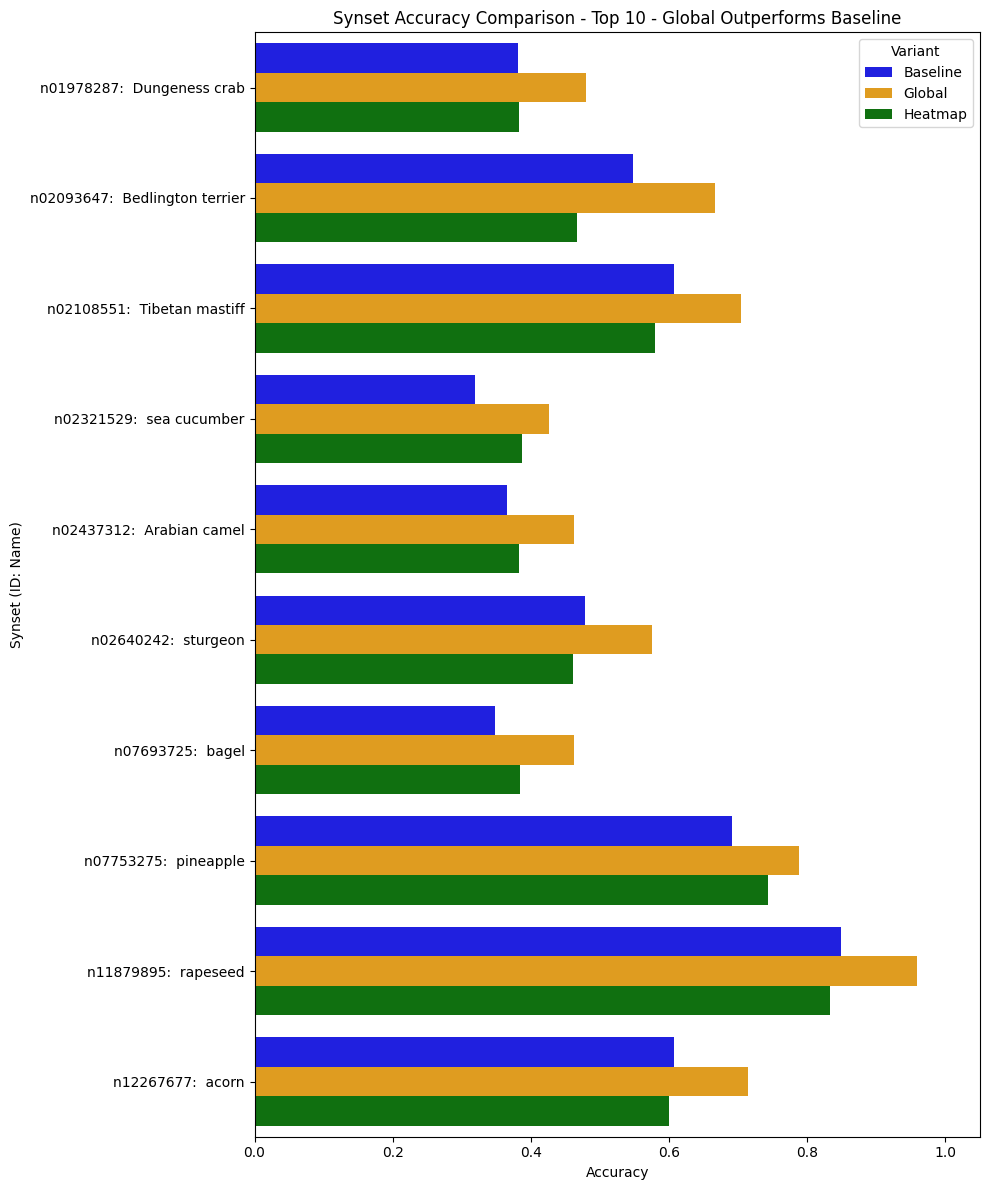


Top 10 synsets where Baseline performed significantly better than Global:
           Baseline    Global   Heatmap  Global_minus_Baseline
synset                                                        
n02443114  0.685714  0.387755  0.500000              -0.297959
n02815834  0.379310  0.090909  0.090909              -0.288401
n03782006  0.428571  0.186047  0.317073              -0.242525
n02483708  0.659091  0.420000  0.500000              -0.239091
n02974003  0.777778  0.540541  0.575758              -0.237237
n03126707  0.553571  0.327869  0.388060              -0.225703
n03443371  0.389831  0.166667  0.219512              -0.223164
n03355925  0.566038  0.350000  0.462963              -0.216038
n06794110  0.625000  0.411765  0.444444              -0.213235
n04039381  0.682927  0.473684  0.571429              -0.209243


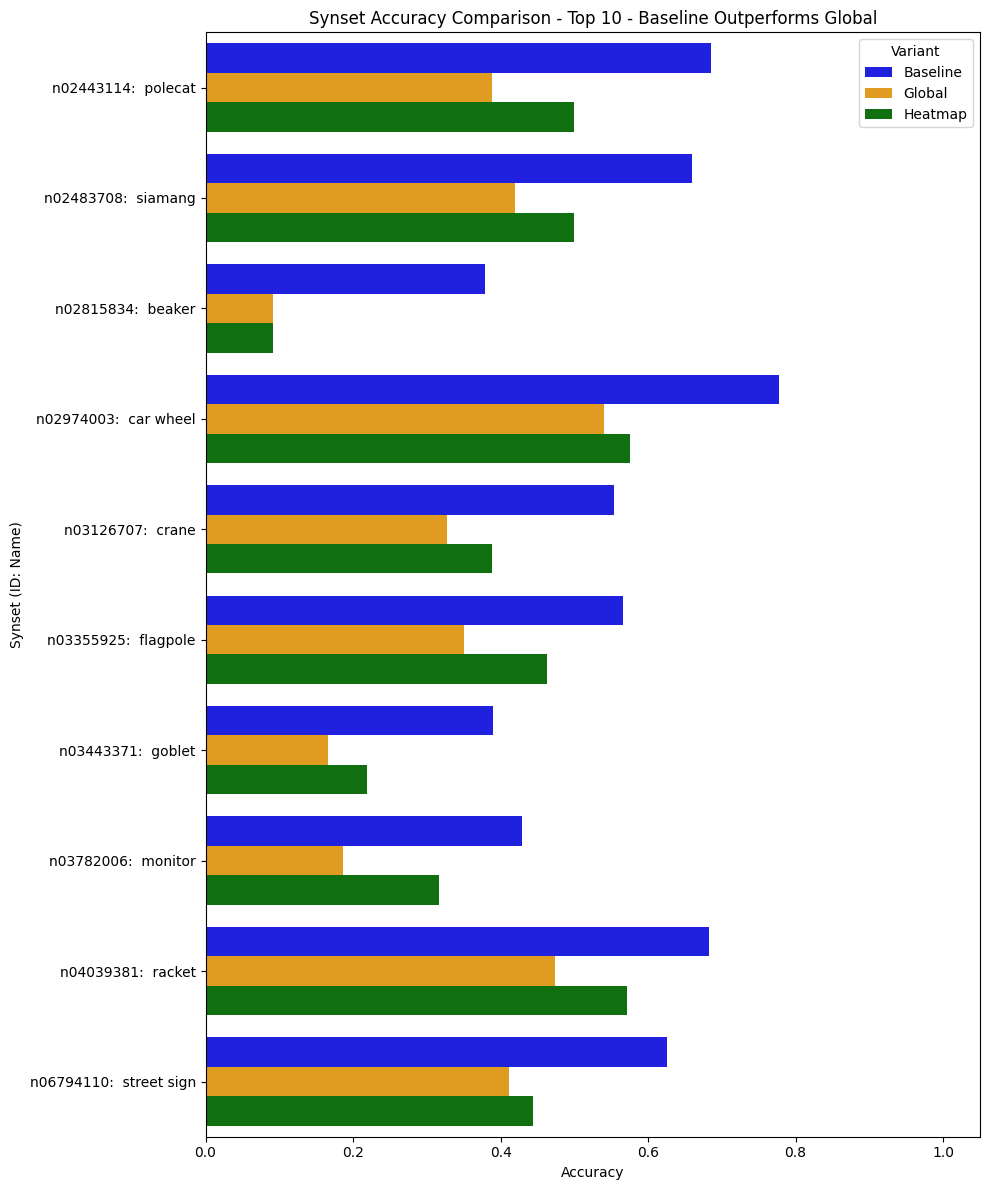


Top 10 synsets where Heatmap performed significantly better than Baseline:
           Baseline    Global   Heatmap  Heatmap_minus_Baseline
synset                                                         
n04336792  0.214286  0.250000  0.363636                0.149351
n01664065  0.500000  0.448276  0.617647                0.117647
n04146614  0.605634  0.666667  0.711538                0.105905
n03804744  0.280000  0.341463  0.377778                0.097778
n02113023  0.373134  0.403509  0.461538                0.088404
n09399592  0.555556  0.642857  0.642857                0.087302
n12998815  0.888889  0.886364  0.976190                0.087302
n03770679  0.468750  0.361702  0.555556                0.086806
n02321529  0.318841  0.425926  0.387755                0.068915
n03345487  0.500000  0.467742  0.561404                0.061404


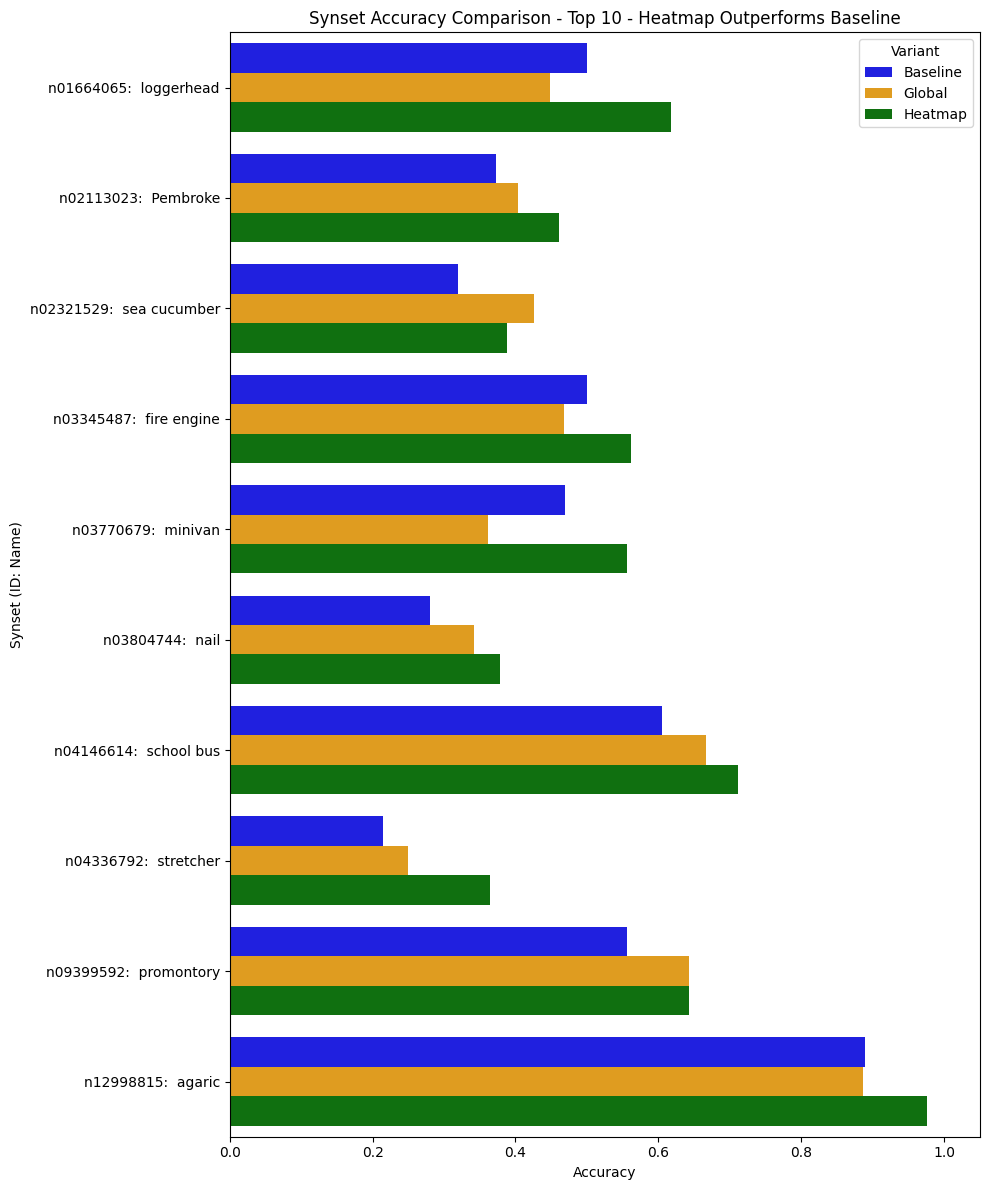


Top 10 synsets where Baseline performed significantly better than Heatmap:
           Baseline    Global   Heatmap  Heatmap_minus_Baseline
synset                                                         
n02815834  0.379310  0.090909  0.090909               -0.288401
n02102480  0.730769  0.542857  0.472222               -0.258547
n03538406  0.515625  0.400000  0.270588               -0.245037
n04532670  0.629630  0.433962  0.411765               -0.217865
n02835271  0.571429  0.538462  0.359375               -0.212054
n02116738  0.787234  0.587302  0.576271               -0.210963
n04479046  0.431818  0.400000  0.222222               -0.209596
n03388549  0.562500  0.388060  0.352941               -0.209559
n09193705  0.723404  0.525424  0.517857               -0.205547
n04099969  0.423077  0.312500  0.220339               -0.202738


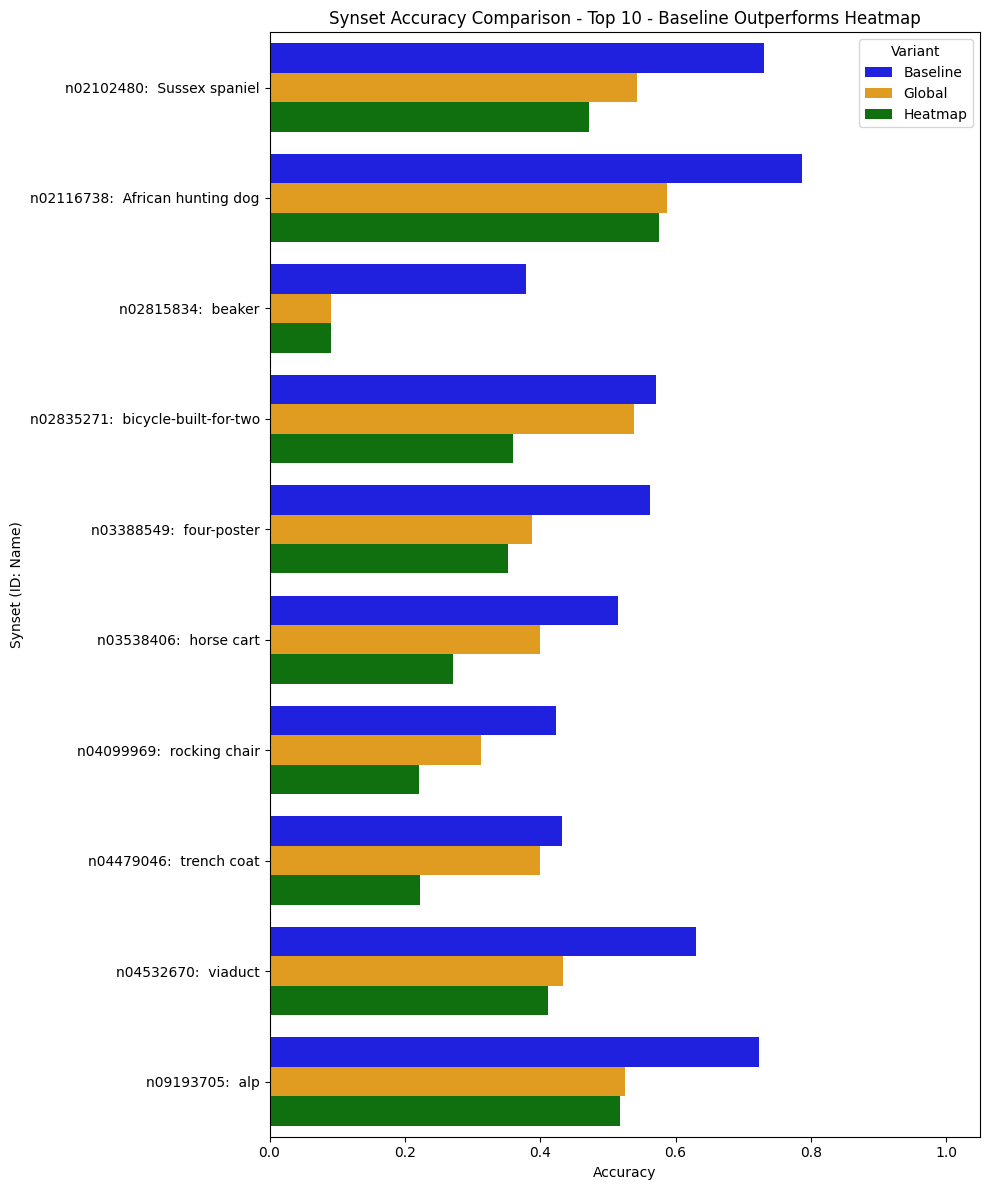

In [44]:
# New cell for focused comparisons against Baseline

# Number of top synsets to display for each comparison
k_top_comparison = 10 # You can adjust this number

# --- 1. Global vs. Baseline Comparison ---
all_accuracies_merged['Global_minus_Baseline'] = all_accuracies_merged['Global'] - all_accuracies_merged['Baseline']

# Synsets where Global performed MUCH BETTER than Baseline
global_better_than_baseline_synsets = all_accuracies_merged.sort_values(by='Global_minus_Baseline', ascending=False).head(k_top_comparison).index.tolist()
if global_better_than_baseline_synsets:
    print(f"\nTop {k_top_comparison} synsets where Global performed significantly better than Baseline:")
    print(all_accuracies_merged.loc[global_better_than_baseline_synsets, ['Baseline', 'Global', 'Heatmap', 'Global_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, global_better_than_baseline_synsets, f"Top {k_top_comparison} - Global Outperforms Baseline")
else:
    print(f"\nNo synsets found where Global clearly outperforms Baseline by a significant margin for top {k_top_comparison}.")

# Synsets where Baseline performed MUCH BETTER than Global (i.e., Global_minus_Baseline is most negative)
baseline_better_than_global_synsets = all_accuracies_merged.sort_values(by='Global_minus_Baseline', ascending=True).head(k_top_comparison).index.tolist()
if baseline_better_than_global_synsets:
    print(f"\nTop {k_top_comparison} synsets where Baseline performed significantly better than Global:")
    print(all_accuracies_merged.loc[baseline_better_than_global_synsets, ['Baseline', 'Global', 'Heatmap', 'Global_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_better_than_global_synsets, f"Top {k_top_comparison} - Baseline Outperforms Global")
else:
    print(f"\nNo synsets found where Baseline clearly outperforms Global by a significant margin for top {k_top_comparison}.")


# --- 2. Heatmap vs. Baseline Comparison ---
all_accuracies_merged['Heatmap_minus_Baseline'] = all_accuracies_merged['Heatmap'] - all_accuracies_merged['Baseline']

# Synsets where Heatmap performed MUCH BETTER than Baseline
heatmap_better_than_baseline_synsets = all_accuracies_merged.sort_values(by='Heatmap_minus_Baseline', ascending=False).head(k_top_comparison).index.tolist()
if heatmap_better_than_baseline_synsets:
    print(f"\nTop {k_top_comparison} synsets where Heatmap performed significantly better than Baseline:")
    print(all_accuracies_merged.loc[heatmap_better_than_baseline_synsets, ['Baseline', 'Global', 'Heatmap', 'Heatmap_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, heatmap_better_than_baseline_synsets, f"Top {k_top_comparison} - Heatmap Outperforms Baseline")
else:
    print(f"\nNo synsets found where Heatmap clearly outperforms Baseline by a significant margin for top {k_top_comparison}.")

# Synsets where Baseline performed MUCH BETTER than Heatmap (i.e., Heatmap_minus_Baseline is most negative)
baseline_better_than_heatmap_synsets = all_accuracies_merged.sort_values(by='Heatmap_minus_Baseline', ascending=True).head(k_top_comparison).index.tolist()
if baseline_better_than_heatmap_synsets:
    print(f"\nTop {k_top_comparison} synsets where Baseline performed significantly better than Heatmap:")
    print(all_accuracies_merged.loc[baseline_better_than_heatmap_synsets, ['Baseline', 'Global', 'Heatmap', 'Heatmap_minus_Baseline']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_better_than_heatmap_synsets, f"Top {k_top_comparison} - Baseline Outperforms Heatmap")
else:
    print(f"\nNo synsets found where Baseline clearly outperforms Heatmap by a significant margin for top {k_top_comparison}.")


Top 10 (out of 94 total) synsets where Baseline outperforms both Global and Heatmap by at least 5% (sorted by Baseline_Advantage):
           Baseline    Global   Heatmap  Baseline_Advantage
synset                                                     
n02815834  0.379310  0.090909  0.090909            0.288401
n02974003  0.777778  0.540541  0.575758            0.202020
n02116738  0.787234  0.587302  0.576271            0.199932
n09193705  0.723404  0.525424  0.517857            0.197981
n04532670  0.629630  0.433962  0.411765            0.195667
n02102480  0.730769  0.542857  0.472222            0.187912
n02443114  0.685714  0.387755  0.500000            0.185714
n06794110  0.625000  0.411765  0.444444            0.180556
n03388549  0.562500  0.388060  0.352941            0.174440
n04389033  0.536585  0.363636  0.352941            0.172949


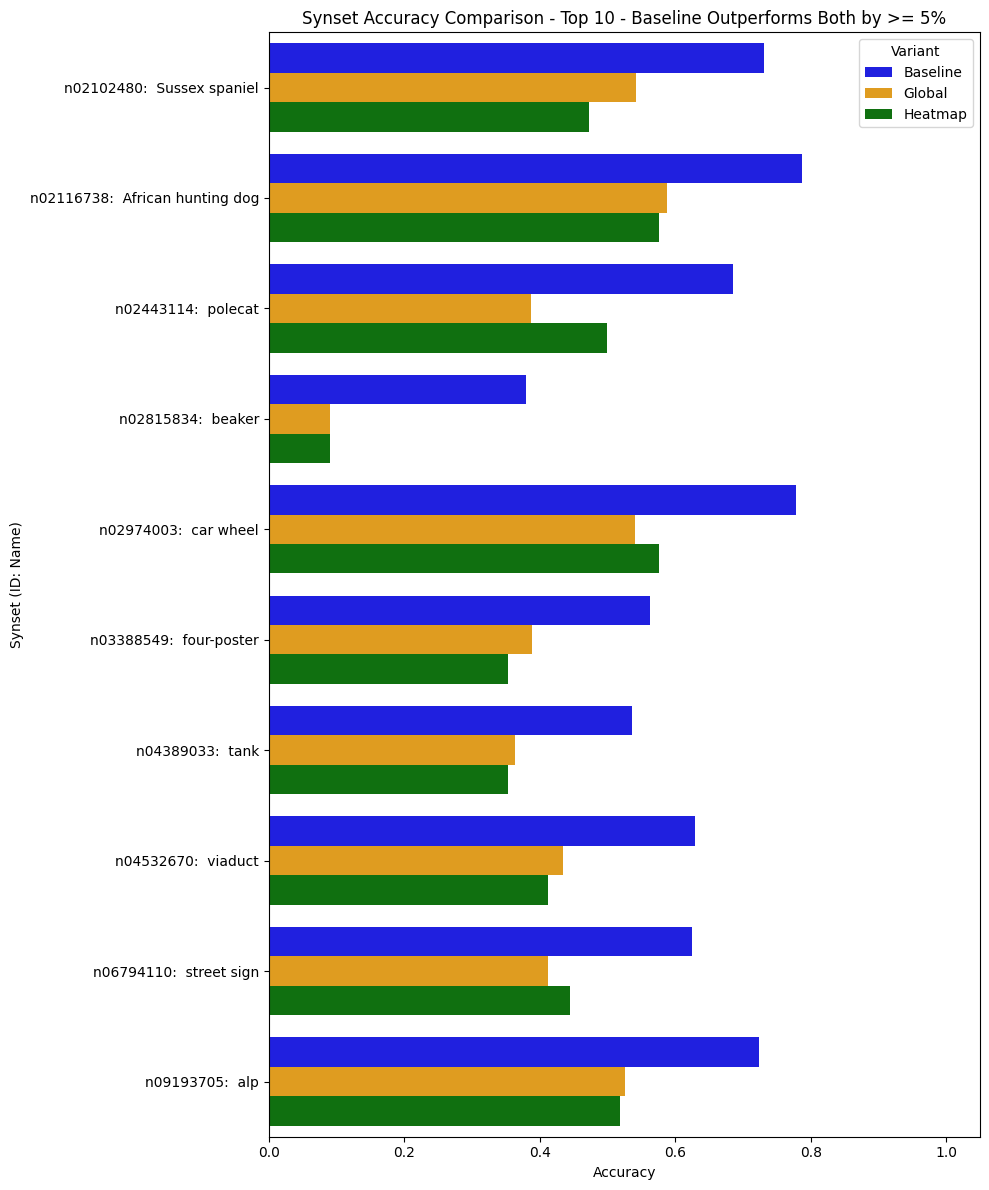


Top 10 (out of 17 total) synsets where Global outperforms both Baseline and Heatmap by at least 5% (sorted by Global_Advantage):
           Baseline    Global   Heatmap  Global_Advantage
synset                                                   
n02093647  0.548387  0.666667  0.466667          0.118280
n11879895  0.849057  0.959184  0.833333          0.110127
n12267677  0.607143  0.714286  0.600000          0.107143
n02108551  0.606557  0.703704  0.578947          0.097146
n01978287  0.380952  0.480000  0.382979          0.097021
n02640242  0.478261  0.575000  0.461538          0.096739
n04090263  0.239130  0.333333  0.190476          0.094203
n02011460  0.596154  0.688889  0.449275          0.092735
n03425413  0.333333  0.423729  0.295775          0.090395
n02120505  0.510204  0.600000  0.440000          0.089796


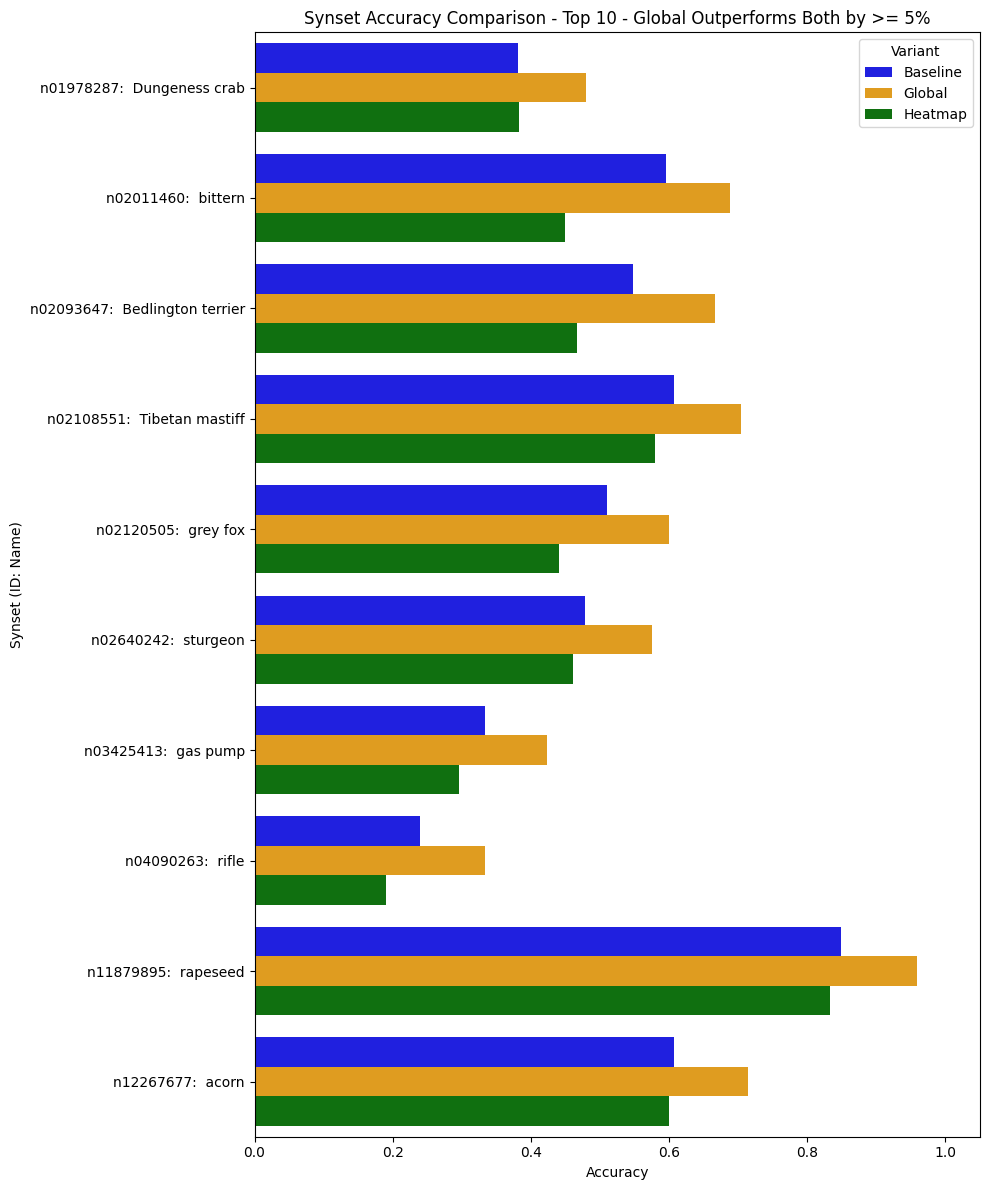


Top 6 (out of 6 total) synsets where Heatmap outperforms both Baseline and Global by at least 5% (sorted by Heatmap_Advantage):
           Baseline    Global   Heatmap  Heatmap_Advantage
synset                                                    
n01664065  0.500000  0.448276  0.617647           0.117647
n04336792  0.214286  0.250000  0.363636           0.113636
n12998815  0.888889  0.886364  0.976190           0.087302
n03770679  0.468750  0.361702  0.555556           0.086806
n03345487  0.500000  0.467742  0.561404           0.061404
n02113023  0.373134  0.403509  0.461538           0.058030


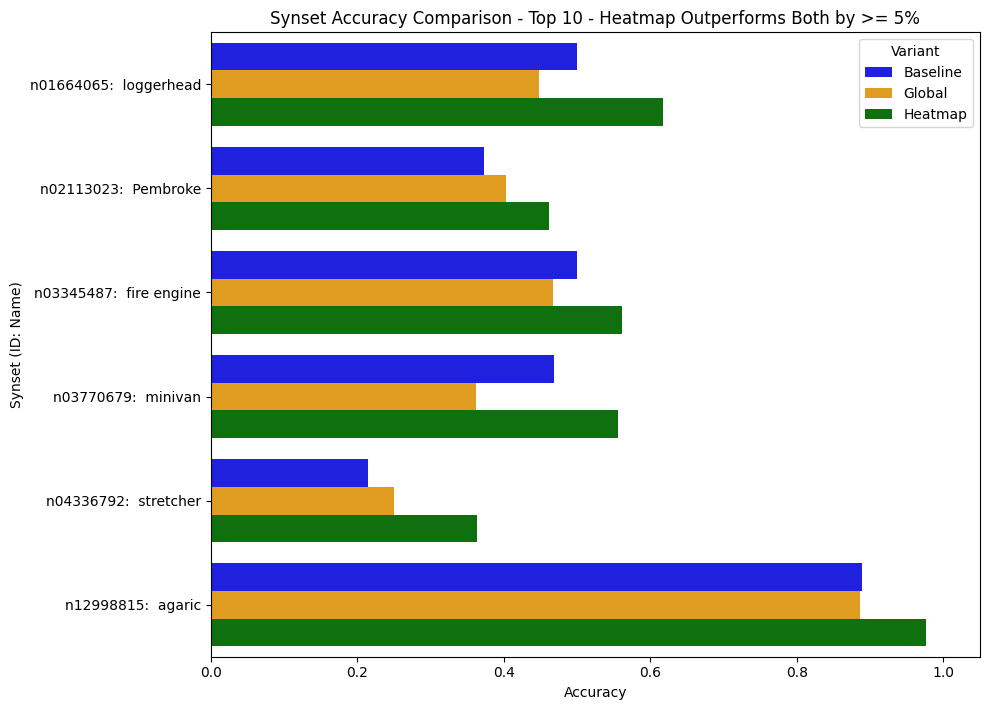


Top 5 (out of 5 total) synsets where Global and Heatmap are SIMILAR (<5%) and BOTH OUTPERFORM Baseline by at least 5%:
           Baseline    Global   Heatmap  GH_Similarity_Diff  \
synset                                                        
n02321529  0.318841  0.425926  0.387755            0.038171   
n09399592  0.555556  0.642857  0.642857            0.000000   
n04146614  0.605634  0.666667  0.711538            0.044872   
n03804744  0.280000  0.341463  0.377778            0.036314   
n07753275  0.690476  0.787879  0.743590            0.044289   

           GH_Avg_vs_Baseline  
synset                         
n02321529            0.088000  
n09399592            0.087302  
n04146614            0.083469  
n03804744            0.079621  
n07753275            0.075258  


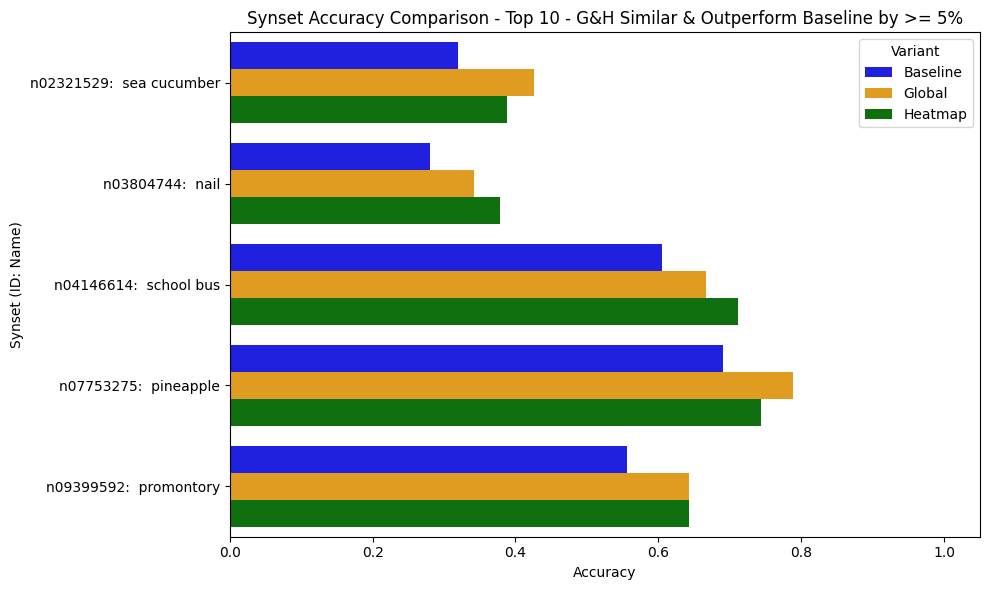


Top 10 (out of 64 total) synsets where Global and Heatmap are SIMILAR (<5%) and BOTH UNDERPERFORM Baseline (Baseline is at least 5% better):
           Baseline    Global   Heatmap  GH_Similarity_Diff  \
synset                                                        
n02815834  0.379310  0.090909  0.090909            0.000000   
n02974003  0.777778  0.540541  0.575758            0.035217   
n04532670  0.629630  0.433962  0.411765            0.022198   
n02116738  0.787234  0.587302  0.576271            0.011030   
n09193705  0.723404  0.525424  0.517857            0.007567   
n06794110  0.625000  0.411765  0.444444            0.032680   
n03388549  0.562500  0.388060  0.352941            0.035119   
n13133613  0.634146  0.446154  0.465517            0.019363   
n04389033  0.536585  0.363636  0.352941            0.010695   
n03661043  0.500000  0.333333  0.328125            0.005208   

           Baseline_vs_GH_Avg  
synset                         
n02815834            0.288401  
n0297

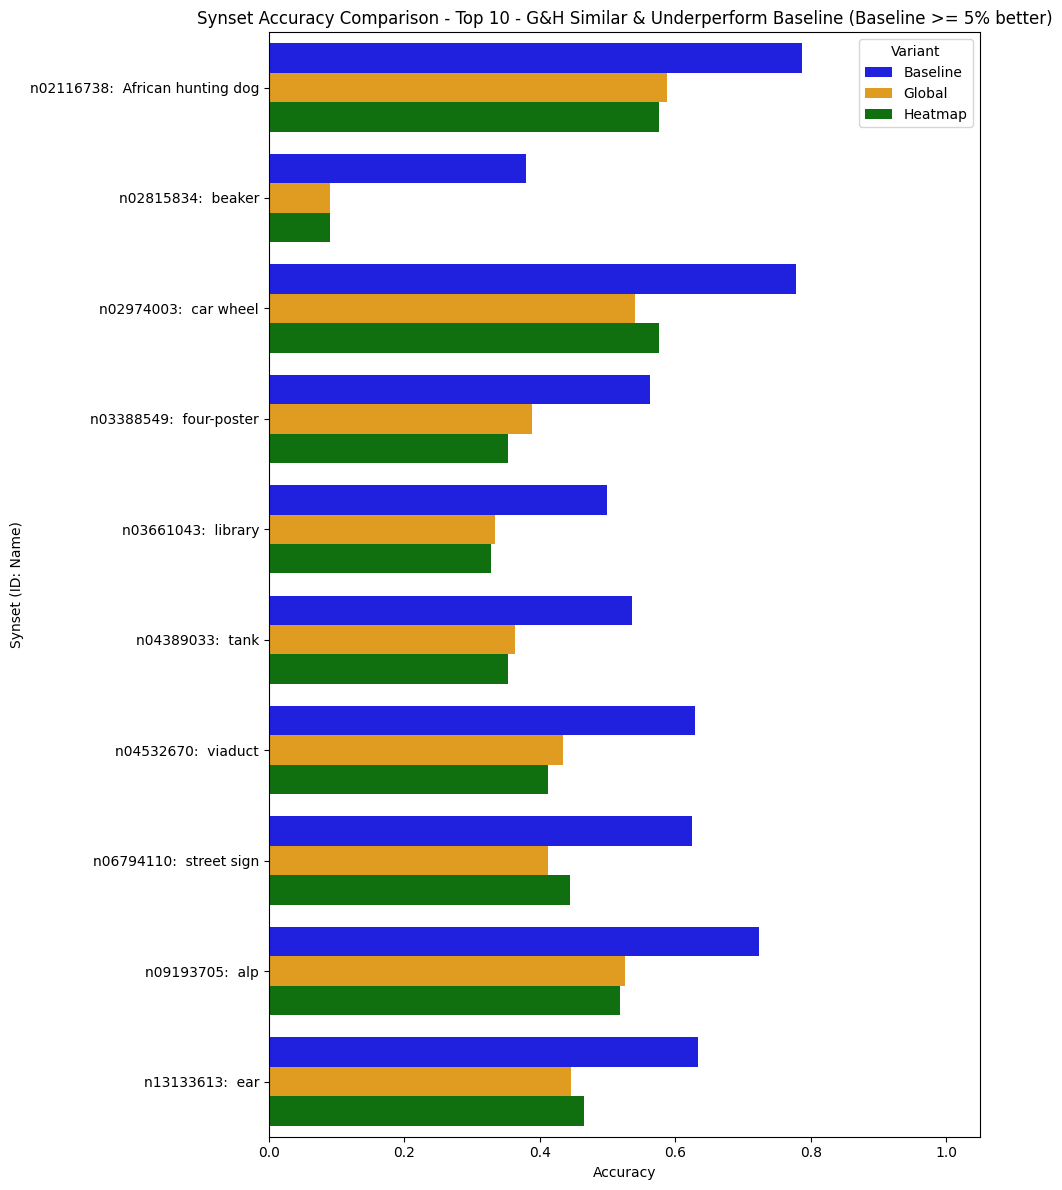

In [47]:
# k_top_excel is assumed to be defined in your environment (e.g., k_top_excel = 10 from the variable list).
# If k_top_excel is not defined, you might need to set it, e.g.:
k_top_excel = 10
similarity_threshold = 0.05 # Define how close "similar" means AND the outperformance margin

# --- 1. Baseline outperforms both Global and Heatmap by at least 5% ---
# We use the 'Baseline_Advantage' column: Baseline - max(Global, Heatmap)
# Positive values >= similarity_threshold mean Baseline is at least 5% better than both.
baseline_excels_df = all_accuracies_merged[all_accuracies_merged['Baseline_Advantage'] >= similarity_threshold].sort_values(by='Baseline_Advantage', ascending=False)
baseline_excels_synsets_list = baseline_excels_df.head(k_top_excel).index.tolist()

if baseline_excels_synsets_list:
    print(f"\nTop {len(baseline_excels_synsets_list)} (out of {len(baseline_excels_df)} total) synsets where Baseline outperforms both Global and Heatmap by at least {similarity_threshold*100:.0f}% (sorted by Baseline_Advantage):")
    print(all_accuracies_merged.loc[baseline_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Baseline_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, baseline_excels_synsets_list, f"Top {k_top_excel} - Baseline Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Baseline outperforms both Global and Heatmap by at least {similarity_threshold*100:.0f}% (total found: {len(baseline_excels_df)}).")

# --- 2. Global outperforms both Baseline and Heatmap by at least 5% ---
# We use the 'Global_Advantage' column: Global - max(Baseline, Heatmap)
global_excels_df = all_accuracies_merged[all_accuracies_merged['Global_Advantage'] >= similarity_threshold].sort_values(by='Global_Advantage', ascending=False)
global_excels_synsets_list = global_excels_df.head(k_top_excel).index.tolist()

if global_excels_synsets_list:
    print(f"\nTop {len(global_excels_synsets_list)} (out of {len(global_excels_df)} total) synsets where Global outperforms both Baseline and Heatmap by at least {similarity_threshold*100:.0f}% (sorted by Global_Advantage):")
    print(all_accuracies_merged.loc[global_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Global_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, global_excels_synsets_list, f"Top {k_top_excel} - Global Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Global outperforms both Baseline and Heatmap by at least {similarity_threshold*100:.0f}% (total found: {len(global_excels_df)}).")

# --- 3. Heatmap outperforms both Baseline and Global by at least 5% ---
# We use the 'Heatmap_Advantage' column: Heatmap - max(Baseline, Global)
heatmap_excels_df = all_accuracies_merged[all_accuracies_merged['Heatmap_Advantage'] >= similarity_threshold].sort_values(by='Heatmap_Advantage', ascending=False)
heatmap_excels_synsets_list = heatmap_excels_df.head(k_top_excel).index.tolist()

if heatmap_excels_synsets_list:
    print(f"\nTop {len(heatmap_excels_synsets_list)} (out of {len(heatmap_excels_df)} total) synsets where Heatmap outperforms both Baseline and Global by at least {similarity_threshold*100:.0f}% (sorted by Heatmap_Advantage):")
    print(all_accuracies_merged.loc[heatmap_excels_synsets_list, ['Baseline', 'Global', 'Heatmap', 'Heatmap_Advantage']])
    plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, heatmap_excels_synsets_list, f"Top {k_top_excel} - Heatmap Outperforms Both by >= {similarity_threshold*100:.0f}%")
else:
    print(f"\nNo synsets to display for top {k_top_excel} where Heatmap outperforms both Baseline and Global by at least {similarity_threshold*100:.0f}% (total found: {len(heatmap_excels_df)}).")

# --- Similarity Comparisons for Global and Heatmap ---
# similarity_threshold = 0.05 # Defined above

# Create a temporary DataFrame for these specific comparisons by copying to avoid modifying the original
temp_df_gh_similar = all_accuracies_merged.copy()
temp_df_gh_similar['GH_Similarity_Diff'] = abs(temp_df_gh_similar['Global'] - temp_df_gh_similar['Heatmap'])

# --- 4. Global and Heatmap similar, AND they OUTPERFORM Baseline by at least 5% ---
# Filter for synsets meeting the criteria
gh_similar_outperform_b_df = temp_df_gh_similar[
    (temp_df_gh_similar['GH_Similarity_Diff'] < similarity_threshold) &
    ((temp_df_gh_similar['Global'] - temp_df_gh_similar['Baseline']) >= similarity_threshold) &
    ((temp_df_gh_similar['Heatmap'] - temp_df_gh_similar['Baseline']) >= similarity_threshold)
].copy() # Use .copy() to ensure it's a new DataFrame

if not gh_similar_outperform_b_df.empty:
    # Calculate how much they outperform Baseline on average
    gh_similar_outperform_b_df['GH_Avg_vs_Baseline'] = \
        (gh_similar_outperform_b_df['Global'] + gh_similar_outperform_b_df['Heatmap']) / 2 - gh_similar_outperform_b_df['Baseline']
    
    gh_similar_outperform_b_df = gh_similar_outperform_b_df.sort_values(by='GH_Avg_vs_Baseline', ascending=False)
    gh_similar_outperform_b_synsets = gh_similar_outperform_b_df.head(k_top_excel).index.tolist()

    if gh_similar_outperform_b_synsets:
        print(f"\nTop {len(gh_similar_outperform_b_synsets)} (out of {len(gh_similar_outperform_b_df)} total) synsets where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}%:")
        print(gh_similar_outperform_b_df.loc[gh_similar_outperform_b_synsets, ['Baseline', 'Global', 'Heatmap', 'GH_Similarity_Diff', 'GH_Avg_vs_Baseline']])
        plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, gh_similar_outperform_b_synsets, f"Top {k_top_excel} - G&H Similar & Outperform Baseline by >= {similarity_threshold*100:.0f}%")
    else:
        print(f"\nNo synsets to display for top {k_top_excel} where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}% (total found: {len(gh_similar_outperform_b_df)}).")
else:
    print(f"\nNo synsets found where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH OUTPERFORM Baseline by at least {similarity_threshold*100:.0f}% (total found: 0).")


# --- 5. Global and Heatmap similar, AND they UNDERPERFORM Baseline (Baseline is at least 5% better) ---
# Filter for synsets meeting the criteria
gh_similar_underperform_b_df = temp_df_gh_similar[
    (temp_df_gh_similar['GH_Similarity_Diff'] < similarity_threshold) &
    ((temp_df_gh_similar['Baseline'] - temp_df_gh_similar['Global']) >= similarity_threshold) &
    ((temp_df_gh_similar['Baseline'] - temp_df_gh_similar['Heatmap']) >= similarity_threshold)
].copy() # Use .copy() to ensure it's a new DataFrame

if not gh_similar_underperform_b_df.empty:
    # Calculate how much Baseline outperforms their average
    gh_similar_underperform_b_df['Baseline_vs_GH_Avg'] = \
        gh_similar_underperform_b_df['Baseline'] - (gh_similar_underperform_b_df['Global'] + gh_similar_underperform_b_df['Heatmap']) / 2
        
    gh_similar_underperform_b_df = gh_similar_underperform_b_df.sort_values(by='Baseline_vs_GH_Avg', ascending=False)
    gh_similar_underperform_b_synsets = gh_similar_underperform_b_df.head(k_top_excel).index.tolist()

    if gh_similar_underperform_b_synsets:
        print(f"\nTop {len(gh_similar_underperform_b_synsets)} (out of {len(gh_similar_underperform_b_df)} total) synsets where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline is at least {similarity_threshold*100:.0f}% better):")
        print(gh_similar_underperform_b_df.loc[gh_similar_underperform_b_synsets, ['Baseline', 'Global', 'Heatmap', 'GH_Similarity_Diff', 'Baseline_vs_GH_Avg']])
        plot_accuracies_subplot(base_accuracy, global_accuracy, heatmap_accuracy, gh_similar_underperform_b_synsets, f"Top {k_top_excel} - G&H Similar & Underperform Baseline (Baseline >= {similarity_threshold*100:.0f}% better)")
    else:
        print(f"\nNo synsets to display for top {k_top_excel} where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline at least {similarity_threshold*100:.0f}% better) (total found: {len(gh_similar_underperform_b_df)}).")
else:
    print(f"\nNo synsets found where Global and Heatmap are SIMILAR (<{similarity_threshold*100:.0f}%) and BOTH UNDERPERFORM Baseline (Baseline at least {similarity_threshold*100:.0f}% better) (total found: 0).")
